## Language Understanding as Bayesian Inference


A set of world states (states of affairs, SOAs) that a set of utterances which can be used to refer to.
$$S = \{\text{blue-square}, \text{blue-circle}, \text{green-square}\}$$
$$U = \{ \text{"square"}, \text{"circle"}, \text{"green"}, \text{"blue"}\}$$

In [216]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt

The vanilla RSA is given below. Each level and term is introduced, from $L_0$ up.
$$P_{L_1}(s \mid u) \propto P_{S_{1}}(u \mid s) \cdot P(s)\$$
$$\downarrow$$
$$P_{S_1}(u \mid s) \propto \exp(\alpha U_{S_1}(u;s))\$$
$$\downarrow$$
$$P_{L_{0}}(s\mid u) \propto [\![u]\!](s) \cdot P(s)$$


### Literal Listeners

$P_{L_{0}}(s\mid u) \propto [\![u]\!](s) \cdot P(s)$
- $P_{L_{0}}(s\mid u)$: probability of inferring state $s$, given utterance $u$
- $[\![u]\!] \colon S \mapsto \{0,1\}$: the denotation function
- $P(s)$: prior probability (belief) of observing states
    - general world knowledge
    - perceptual salience
    - distance from listener/speaker
    - presence of joint attention

Then, a literal listener encodes mapping from utterances to world states: $P_{L_{0}} \colon U \mapsto \Delta^S$.

In [217]:
def normalize(x, axis):
    return x / x.sum(axis=axis, keepdims=True)

In [218]:
objects = ["blue square", "blue circle", "green square"]
utterances = ["blue", "green", "square", "circle"]

def meaning(u, o):
    return float(u in o)
def denotation(u, s):
    return np.array([meaning(u, o) for o in s])

us = np.array([denotation(utr, objects) for utr in utterances])

l0 = normalize(us, 1)
pd.DataFrame(l0, columns=objects, index=utterances)

,blue square,blue circle,green square
blue,0.5,0.5,0.0
green,0.0,0.0,1.0
square,0.5,0.0,0.5
circle,0.0,1.0,0.0


In [219]:
denotation("blue",objects)

array([1., 1., 0.])

Sampling: [L0, prior]
Sampling: [L0, prior]
Sampling: [L0, prior]
Sampling: [L0, prior]


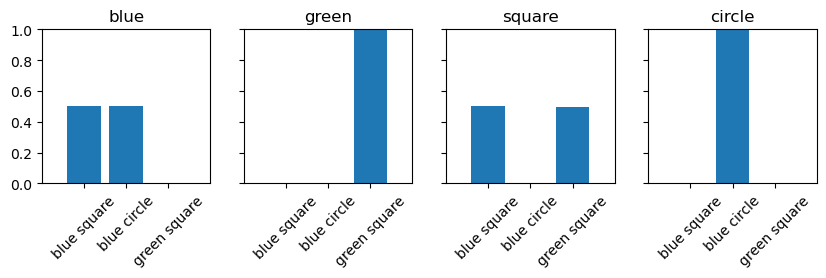

In [220]:
fig, ax = plt.subplots(1, len(utterances), sharey=True, figsize=(10,2))
p_vals = np.zeros((len(utterances), len(objects))) * np.nan
n_samples = 4000
# for each possible utterance
for iu, u_in in enumerate(utterances):
    # create a model that returns state inference probabilities
    with pm.Model() as m:
        # prior over objects
        
        # TODO: make it work with categorical

        # Categorical
        # prior_s = pm.Categorical('prior', p=np.repeat(1/len(objects), len(objects)))
        # u_s = pm.Deterministic('denotation', denotation(u_in, objects) * (prior_s + 1))
        
        # Categorical - biased
        # prior_s = pm.Categorical('prior', p=np.array([0.01, 0.01, 0.98]))
        # u_s = pm.Deterministic('denotation', denotation(u_in, objects) * (prior_s + 1))

        # Dirichlet
        prior_s = pm.Dirichlet('prior', a=np.repeat(1, len(objects)))
        # prior_s = pm.Dirichlet('prior', a=np.array([1, 1, 8]))
        u_s = pm.Deterministic('denotation', denotation(u_in, objects) * prior_s)
        
        # L0
        pm.Categorical('L0',
                    p=normalize(u_s, axis=0))
        idata = pm.sample_prior_predictive(samples=n_samples)

    category_vals = idata.prior.L0.stack(samples=('chain','draw'))
    cat, count = np.unique(category_vals, return_counts=True)

    for ic, c in enumerate(cat):
        p_vals[iu, c] = count[ic] / n_samples
    
    ax[iu].bar(cat, count/n_samples)
    ax[iu].set_title(u_in)
    ax[iu].set_ylim([0,1])
    ax[iu].set_xticks(np.arange(len(objects)))
    ax[iu].set_xlim([-1, len(objects)])
    ax[iu].tick_params(axis="x", labelrotation=45)
    ax[iu].set_xticklabels(objects);

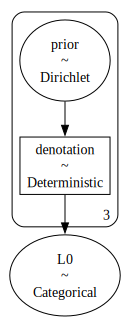

In [221]:
pm.model_to_graphviz(m)

In [222]:
p_vals

array([[0.5005 , 0.4995 ,     nan],
       [    nan,     nan, 1.     ],
       [0.50075,     nan, 0.49925],
       [    nan, 1.     ,     nan]])

#### Softmax Decisions

$$P(a_i) = \frac{\exp(\alpha \cdot \text{Util}(a_i))}{\sum_{j} \exp(\alpha \cdot \text{Util}(a_j))}$$

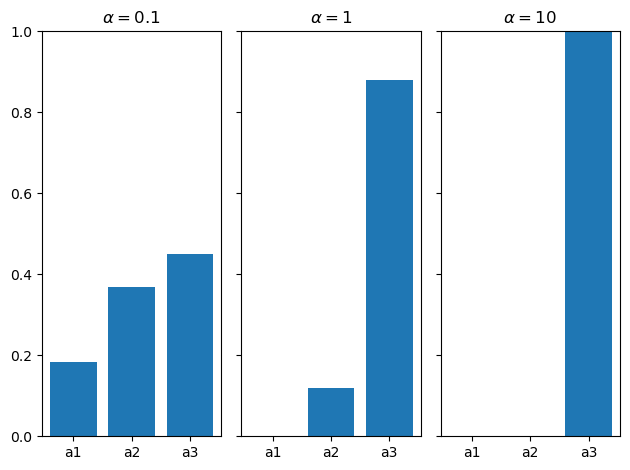

In [223]:
def softmax(alpha, vals):
    # return np.exp(alpha * vals) / np.sum(np.exp(alpha*vals))
    return normalize(np.exp(alpha * vals), 0)

alphas = [0.1, 1, 10]
fig, ax = plt.subplots(1,3, sharey=True)
for i in range(3):
    ax[i].set_ylim([0,1])
    ax[i].bar(np.arange(3),softmax(alphas[i], np.array([-1, 6, 8])))
    ax[i].set_xticks(np.arange(3))
    ax[i].set_xticklabels(['a1','a2','a3'])
    ax[i].set_title(r'$\alpha=$' + str(alphas[i]))
plt.tight_layout()

### Speaker 1

Bayesian decision making based on a utility function:
$$U_{S_{1}}(u; s) = \log P_{L_{0}}(s\mid u) - C(u)$$
- Utility maximization = surprisal minimization and cost minimization
- Surprise: $-log(p)$, high if evidence has a low probability of being observed
- another interpretation: amount of information gain by observing a particular sample from a known distribution
- another one: decreasing the KL-divergence between speaker's and listener's distributions

The speaker utterance probabilities for an intended referent:
$$P_{S_1}(u \mid s) \propto \exp(\alpha (\log P_{L_{0}}(s\mid u) - C(u)))\$$

In [ ]:
# set costs to zero for now
def cost(u):
    cost_dict = dict(zip(utterances, np.repeat(0, len(utterances))))
    return cost_dict[u]

cost_vec = np.array([cost(u) for u in utterances]).reshape(len(utterances), 1)
cost_vec

array([[0],
       [0],
       [0],
       [0]])

In [ ]:
def vanilla_rsa(tau_S, l0):
    """Vanilla RSA with 1 iteration over literals: a speaker and a pragmatic listener.
    Args:
    - tau_S: speaker's rationality (optimality)
    - l0: denotation mapping
    Returns:
    idata with prior predictives on two categorical distributions
    - S1: speaker
    - L1: pragmatic listener
    """
    with pm.Model() as m_RSA:
        
        # P_S1(u|P_L0)
        S1 = pm.Deterministic(
            'S1',
            normalize(
                pt.exp(
                    tau_S * (
                        pt.log(l0) - cost_vec
                    )                    
                ),
                0
            )
        )

        L1 = pm.Deterministic(
            'L1',
            normalize(
                S1,
                1
            )
        )
        
        pm.Categorical('pL1',
                        p=L1)
        
        idata = pm.sample_prior_predictive()
    
        return idata

In [226]:
def RSA_pTables(alpha, l0):
    idata = vanilla_rsa(alpha, l0)
    # literal listener
    print("L0")
    print(pd.DataFrame(l0, columns=objects, index=utterances))
    # speaker
    S1_ = idata.prior.S1.stack(samples=("chain", "draw")).mean(axis=2).T.values
    print("S1")
    print(pd.DataFrame(S1_, columns=utterances, index=objects))
    # pragmatic listener
    L1_ = idata.prior.L1.stack(samples=("chain", "draw")).mean(axis=2)
    print("L1")
    print(pd.DataFrame(L1_, columns=objects, index=utterances))

In [227]:
RSA_pTables(1, l0)

Sampling: [pL1]


L0
        blue square  blue circle  green square
blue            0.5          0.5           0.0
green           0.0          0.0           1.0
square          0.5          0.0           0.5
circle          0.0          1.0           0.0
S1
                  blue     green    square    circle
blue square   0.500000  0.000000  0.500000  0.000000
blue circle   0.333333  0.000000  0.000000  0.666667
green square  0.000000  0.666667  0.333333  0.000000
L1
        blue square  blue circle  green square
blue            0.6          0.4           0.0
green           0.0          0.0           1.0
square          0.6          0.0           0.4
circle          0.0          1.0           0.0


In [228]:
# a more optimal speaker (e.g. alpha = 10)
RSA_pTables(10, l0)

Sampling: [pL1]


L0
        blue square  blue circle  green square
blue            0.5          0.5           0.0
green           0.0          0.0           1.0
square          0.5          0.0           0.5
circle          0.0          1.0           0.0
S1
                  blue     green    square    circle
blue square   0.500000  0.000000  0.500000  0.000000
blue circle   0.000976  0.000000  0.000000  0.999024
green square  0.000000  0.999024  0.000976  0.000000
L1
        blue square  blue circle  green square
blue       0.998053     0.001947      0.000000
green      0.000000     0.000000      1.000000
square     0.998053     0.000000      0.001947
circle     0.000000     1.000000      0.000000


Making the speaker more optimal makes speaker depend more on listener interpretation probabilities. As the $\alpha$ value gets larger, the speaker behaves like a maximum-utility agent. In this case since $P_{L_0}(\text{blue-circle} \mid u)$ for $u=\text{circle}$ is greater than $u=\text{blue}$, and costs are simply zero, the utility maximizing utterance turns out to be $u=\text{circle}$ for $S_1$. Note that for lower values of optimality parameter the speaker starts to choose utterances randomly.

In [236]:
# adding a new object
objects = ["blue square", "blue circle", "green square", "green circle"]

us = np.array([denotation(utr, objects) for utr in utterances])

l0 = normalize(us, 1)

In [237]:
RSA_pTables(1, l0)

Sampling: [pL1]


L0
        blue square  blue circle  green square  green circle
blue            0.5          0.5           0.0           0.0
green           0.0          0.0           0.5           0.5
square          0.5          0.0           0.5           0.0
circle          0.0          0.5           0.0           0.5
S1
              blue  green  square  circle
blue square    0.5    0.0     0.5     0.0
blue circle    0.5    0.0     0.0     0.5
green square   0.0    0.5     0.5     0.0
green circle   0.0    0.5     0.0     0.5
L1
        blue square  blue circle  green square  green circle
blue            0.5          0.5           0.0           0.0
green           0.0          0.0           0.5           0.5
square          0.5          0.0           0.5           0.0
circle          0.0          0.5           0.0           0.5


In [244]:
# adding a new multi-word utterance
objects = ["blue square", "blue circle", "green square", "green circle"]
utterances = ["blue", "green", "square", "circle", "green square"]

us = np.array([denotation(utr, objects) for utr in utterances])

l0 = normalize(us, 1)
pd.DataFrame(l0, columns=objects, index=utterances)

,blue square,blue circle,green square,green circle
blue,0.5,0.5,0.0,0.0
green,0.0,0.0,0.5,0.5
square,0.5,0.0,0.5,0.0
circle,0.0,0.5,0.0,0.5
green square,0.0,0.0,1.0,0.0


In [246]:
cost_vec = np.array([cost(u) for u in utterances]).reshape(len(utterances), 1)
RSA_pTables(1, l0)

Sampling: [pL1]


L0
              blue square  blue circle  green square  green circle
blue                  0.5          0.5           0.0           0.0
green                 0.0          0.0           0.5           0.5
square                0.5          0.0           0.5           0.0
circle                0.0          0.5           0.0           0.5
green square          0.0          0.0           1.0           0.0
S1
              blue  green  square  circle  green square
blue square    0.5   0.00    0.50     0.0           0.0
blue circle    0.5   0.00    0.00     0.5           0.0
green square   0.0   0.25    0.25     0.0           0.5
green circle   0.0   0.50    0.00     0.5           0.0
L1
              blue square  blue circle  green square  green circle
blue             0.500000          0.5      0.000000      0.000000
green            0.000000          0.0      0.333333      0.666667
square           0.666667          0.0      0.333333      0.000000
circle           0.000000          0.5   

Blue cannot refer to something green because denotation function does not allow it.